# Stock Trading

The cell below defines the **abstract class** whose API you need to implement. **Do NOT modify it** - use the dedicated cell further below for your implementation instead.

In [1]:
# DO NOT MODIFY THIS CELL

from abc import ABC, abstractmethod  
      

# abstract class to represent a stock trading platform
class AbstractStockTradingPlatform(ABC):
    
    # constructor
    @abstractmethod
    def __init__(self):
        pass           
        
    # adds transactionRecord to the set of completed transactions
    @abstractmethod
    def logTransaction(self, transactionRecord):
        pass

    # returns a list with all transactions of a given stockName,
    # sorted by increasing trade value. 
    # stockName : str
    @abstractmethod
    def sortedTransactions(self, stockName): 
        sortedList = []
        return sortedList    
    
    # returns a list of transactions of a given stockName with minimum trade value
    # stockName : str
    @abstractmethod
    def minTransactions(self, stockName): 
        minList = []
        return minList    
    
    # returns a list of transactions of a given stockName with maximum trade value
    # stockName : str
    @abstractmethod
    def maxTransactions(self, stockName): 
        maxList = []
        return maxList    

    # returns a list of transactions of a given stockName, 
    # with the largest trade value below a given thresholdValue.  
    # stockName : str
    # thresholdValue : double
    @abstractmethod
    def floorTransactions(self, stockName, thresholdValue): 
        floorList = []
        return floorList    

    # returns a list of transactions of a given stockName, 
    # with the smallest trade value above a given thresholdValue.  
    # stockName : str
    # thresholdValue : double
    @abstractmethod
    def ceilingTransactions(self, stockName, thresholdValue): 
        ceilingList = []
        return ceilingList    

        
    # returns a list of transactions of a given stockName,  
    # whose trade value is within the range [fromValue, toValue].
    # stockName : str
    # fromValue : double
    # toValue : double
    @abstractmethod
    def rangeTransactions(self, stockName, fromValue, toValue): 
        rangeList = []
        return rangeList    

Use the cell below to define any data structure and auxiliary python function you may need. Leave the implementation of the main API to the next code cell instead.

In [2]:
# Represents a base transaction class
class NullTransaction:

    ValuePrecision = 0.001

    def __init__(self, price=0, quantity=0, time=0, value=0):

        self.price = price
        self.quantity = quantity
        self.time = time
        self.value = value

    # Performs float comparisons with other transactions based on its trade value.
    # E.g. (t1 <= t2) == TRUE where t1.value <= t2.value
    def __eq__(self, other):

        return abs(self.value - other.value) < NullTransaction.ValuePrecision

    def __lt__(self, other):

        return (other.value - self.value) > NullTransaction.ValuePrecision

    def __le__(self, other):

        return self < other or self == other

    def __str__(self):

        return "Price: %.3f | Quantity: %.3f | Time: %s | Value: %.3f" % (self.price, self.quantity, self.time, self.value)

    def __repr__(self):

        return "\n" + str(self) + "\n"

# A transaction class that unpacks tuple-formatted transaction records as required.
# Company name not stored, this is unambiguous in our API.
class RecordTransaction(NullTransaction):

    def __init__(self, record):

        self.price = record[1]
        self.quantity = record[2]
        self.time = record[3]

        self.value = self.price * self.quantity

# Our custom Red-Black tree nodes
# Holds a list of transactions with matching trade value
# Sort key is the first transaction of this list.
class TransactionNode:

    Black = False
    Red = True

    def __init__(self, key):

        self.key = key
        self.list = [self.key]

        self.left = None
        self.right = None

        self.colour = TransactionNode.Black

# Holds transactions in a Left-Leaning Red-Black BST.
class TransactionTree:

    # Helper functions 

    @staticmethod
    def applyLeftRotation(node):

        parent = node.right
        node.right = parent.left
        parent.left = node

        parent.colour = node.colour
        node.colour = TransactionNode.Red

        return parent

    @staticmethod
    def applyRightRotation(node):

        parent = node.left
        node.left = parent.right
        parent.right = node

        parent.colour = node.colour
        node.colour = TransactionNode.Red

        return parent
    
    @staticmethod
    def flipColours(node):

        node.colour = not node.colour

        node.left.colour = not node.left.colour
        node.right.colour = not node.right.colour

    @staticmethod
    def insertNode(node, key):

        if node is None:

            node = TransactionNode(key)
            node.colour = TransactionNode.Red

            return node

        elif key < node.key:

            node.left = TransactionTree.insertNode(node.left, key)

        elif key > node.key:

            node.right = TransactionTree.insertNode(node.right, key)

        elif key == node.key:

            node.list.append(key)

            return node

        # Balancing operations

        leftRed = node.left is not None and node.left.colour
        rightRed = node.right is not None and node.right.colour

        if rightRed and not leftRed:
            node = TransactionTree.applyLeftRotation(node)

        leftChildRed = node.left is not None and node.left.left is not None and node.left.left.colour

        if leftRed and leftChildRed:
            node = TransactionTree.applyRightRotation(node)

        if leftRed and rightRed:
            TransactionTree.flipColours(node)

        return node

    @staticmethod
    def findNode(node, key):

        while node is not None:

            if key < node.key:
                node = node.left

            elif key > node.key:
                node.right

            else:
                return node

        return None

    # Class methods

    def __init__(self):

        self.root = None

    def find(self, transaction):

        return TransactionTree.findNode(self.root, transaction)

    def insert(self, transaction):

        self.root = TransactionTree.insertNode(self.root, transaction)
        self.root.colour = TransactionNode.Black

    def getHeight(self):

        def nextLevel(node):

            if node is None:
                return -1

            return 1 + max(nextLevel(node.left), nextLevel(node.right))

        return nextLevel(self.root)

    def toList(self):

        transactions = []

        def flatten(node):

            if node is None:
                return

            flatten(node.left)
            transactions.extend(node.list)
            flatten(node.right)

        flatten(self.root)

        return transactions

    def minima(self):

        def nextMin(node):

            if node is None:
                return []

            elif node.left is None:
                return node.list

            else:
                return nextMin(node.left)

        return nextMin(self.root)

    def maxima(self):

        def nextMax(node):

            if node is None:
                return []

            elif node.right is None:
                return node.list

            else:
                return nextMax(node.right)

        return nextMax(self.root)

    def floor(self, threshold):

        node = self.root
        floorTransactions = []

        key = NullTransaction(value=threshold)

        while node is not None:

            if node.key == key:

                floorTransactions = node.list
                break

            elif node.key > key:

                node = node.left

            else:

                floorTransactions = node.list
                node = node.right

        return floorTransactions

    def ceil(self, threshold):

        node = self.root
        ceilTransactions = []

        key = NullTransaction(value=threshold)

        while node is not None:

            if node.key == key:

                ceilTransactions = node.list
                break

            elif node.key > key:

                ceilTransactions = node.list
                node = node.left

            else:

                node = node.right

        return ceilTransactions

    def range(self, fromValue, toValue):

        startKey = NullTransaction(value=fromValue)
        endKey = NullTransaction(value=toValue)

        rangeTransactions = []

        def nextRange(node):

            if node is None:

                return

            if node.key > startKey:

                nextRange(node.left)

            if startKey <= node.key <= endKey:

                rangeTransactions.extend(node.list)

            if node.key < endKey:

                nextRange(node.right)

        nextRange(self.root)

        return rangeTransactions


Use the cell below to implement the requested API. 

In [3]:
# Our stock trading platform wrapper
# Makes use of a dictionary to store company trees in one directory.
class StockTradingPlatform(AbstractStockTradingPlatform):

    StockNames = ["Barclays", "HSBA", "Lloyds Banking Group", "NatWest Group", 
        "Standard Chartered", "3i", "Abrdn", "Hargreaves Lansdown", 
        "London Stock Exchange Group", "Pershing Square Holdings", 
        "Schroders", "St. James's Place plc."]
    
    def __init__(self):
        
        self.directory = dict()

        for company in StockTradingPlatform.StockNames:
            self.directory[company] = TransactionTree()

    def logTransaction(self, transactionRecord):
        
        stockName = transactionRecord[0]
        transaction = RecordTransaction(transactionRecord)

        self.directory[stockName].insert(transaction)

    def sortedTransactions(self, stockName): 

        return self.directory[stockName].toList()    
    
    def minTransactions(self, stockName): 

        return self.directory[stockName].minima() 
    
    def maxTransactions(self, stockName): 
        
        return self.directory[stockName].maxima()   

    def floorTransactions(self, stockName, thresholdValue): 
        
        return self.directory[stockName].floor(thresholdValue)

    def ceilingTransactions(self, stockName, thresholdValue): 

        return self.directory[stockName].ceil(thresholdValue)  
    
    def rangeTransactions(self, stockName, fromValue, toValue): 
        
        return self.directory[stockName].range(fromValue, toValue)


The cell below provides helper code that you can use within your experimental framework to generate random transaction data. **Do NOT modify it**.

In [4]:
# DO NOT MODIFY THIS CELL

import random
from datetime import timedelta
from datetime import datetime

class TransactionDataGenerator:
    def __init__(self):
        self.stockNames = ["Barclays", "HSBA", "Lloyds Banking Group", "NatWest Group", 
                      "Standard Chartered", "3i", "Abrdn", "Hargreaves Lansdown", 
                      "London Stock Exchange Group", "Pershing Square Holdings", 
                      "Schroders", "St. James's Place plc."]
        self.minTradeValue = 500.00
        self.maxTradeValue = 100000.00
        self.startDate = datetime.strptime('1/1/2022 1:00:00', '%d/%m/%Y %H:%M:%S')
        random.seed(20221603)
          
    # returns the name of a traded stock at random
    def getStockName(self):
        return random.choice(self.stockNames)

    # returns the trade value of a transaction at random
    def getTradeValue(self):
        return round(random.uniform(self.minTradeValue, self.maxTradeValue), 2)
    
    # returns a list of N randomly generated transactions,
    # where each transaction is represented as a list [stock name, price, quantity, timestamp]
    # N : int
    def generateTransactionData(self, N):   
        listTransactions = [[]]*N
        listDates = [self.startDate + timedelta(seconds=3*x) for x in range(0, N)]
        listDatesFormatted = [x.strftime('%d/%m/%Y %H:%M:%S') for x in listDates]
        for i in range(N):
            stockName = random.choice(self.stockNames)
            price = round(random.uniform(50.00, 100.00), 2)
            quantity = random.randint(10,1000)
            listTransactions[i] = [stockName, price, quantity, listDatesFormatted[i]]   
        return listTransactions

Use the cell below for the python code needed to realise your **experimental framework** (i.e., to generate test data, to instante the `StockTrading` class, to thorouhgly experiment with its API functions, and to experimentally measure their performance). You may use the previously provided ``TransactionDataGenerator`` class to generate random transaction data.

In [5]:
import random
import timeit

###################################################################################################################
# Note on timeit:                                                                                                 #
# We make extensive use of this timing function: timeit.timeit(lambda: someFunctionToTest())                      # 
# This is slower than measuring time deltas alone, but it automatically disables garbage collector.               #
# We found doing this dramatically improves the quality of our data, and this no longer requires importing 'gc'   #
###################################################################################################################

############################################################################################################################
# A test data generator that creates grouped test data, useful for evaluating performance of individual search trees etc.  #
############################################################################################################################
class SpecificDataGenerator(TransactionDataGenerator):

    def __init__(self):

        super().__init__()

        self.allStocks = self.stockNames.copy()
        self.stockNames = []

    #################################################################
    # Solution to cleanly override included generator function      #
    # Provides N random transactions per company, in separate bins. #
    #################################################################
    def generateGroupedTransactionData(self, N):
        
        groupedTransactions = []
        for i in range(len(self.allStocks)):

            self.stockNames = [self.allStocks[i]]
            groupedTransactions.append(self.generateTransactionData(N))

        return groupedTransactions

##############################################################################
# A generic evaluator for evaluating behaviour with increasing transactions  #
# E.g. generating time complexity graphs for log behaviour.                  #
##############################################################################
class PlatformEvaluator:

    def __init__(self):

        self.platform = StockTradingPlatform()
        self.generator = SpecificDataGenerator()

        self.dataset = None

        self.operations = 0
        self.intervals = 0

    def setup(self, operations=10000, intervals=50):

        self.dataset = self.generator.generateGroupedTransactionData(operations)
        
        self.operations = operations
        self.intervals = intervals

    def run(self, func, autoInsert=True):

        binSize = self.operations // self.intervals

        # Perform test
        xValues = []
        yValues = []
        for i in range(self.intervals):

            n = i*binSize
            xValues.append(n)

            platformAvg = 0
            for (company, companyData) in zip(StockTradingPlatform.StockNames, self.dataset):

                companyAvg = 0
                binData = companyData[i*binSize:(i+1)*binSize]

                for record in binData:
                    
                    if autoInsert:
                        self.platform.logTransaction(record)

                    result = func(company, record)

                    companyAvg += result
                
                companyAvg /= binSize
                platformAvg += companyAvg

            platformAvg /= len(self.dataset)
            yValues.append(platformAvg)

        return xValues, yValues

################################################################################
# Test 1: Initialise platform, randomly log many transactions                  #
# Ensures insertion time is roughly equal between companies as each tree grows #
################################################################################

def testInsertionPerformanceAcrossCompanies(platform, groupedTransactions):

    # Perform interleaved insertions into each company rather than one-by-one
    transactionsPerCompany = len(groupedTransactions[0])
    companyCount = len(groupedTransactions)
    totalTransactions = transactionsPerCompany * companyCount
    
    timings = [[] for t in range(companyCount)]
    for i in range(transactionsPerCompany):

        for j in range(len(groupedTransactions)):

            record = groupedTransactions[j][i]
            interval = timeit.timeit(lambda:platform.logTransaction(record), number=1) * 1000

            timings[j].append(interval)

    mins = []
    maxes = []
    avgs = []
    totalTime = 0
    for companyTimes in timings:

        mins.append(min(companyTimes))
        maxes.append(max(companyTimes))
        avgs.append(sum(companyTimes)/len(companyTimes))

        totalTime += sum(companyTimes)

    print("Logged %d transactions in %.3f seconds total." %(totalTransactions, totalTime/1000))
    print("Best time: %.3f ms | Average time: %.3f ms | Worst time: %.3f ms" %(min(mins), totalTime/totalTransactions, max(maxes)))
    print()

    for company, avg in zip(StockTradingPlatform.StockNames, avgs):
        
        print("Average insertion time for %s: %.3f ms" %(company, avg))


################################################################################
# Test 2: Check transaction sorting and tree flattening functions              #
# Ensures all loggedTransactions are stored correctly, in sorted order.        #
# Ensure min and max return the most extreme values.                           #
################################################################################

def testSortingOrder(platform, transactions):

    for i in range(len(StockTradingPlatform.StockNames)):
        
        company = StockTradingPlatform.StockNames[i]
        
        elapsed = timeit.timeit(lambda:platform.sortedTransactions(company), number=1) * 1000000
        testList = platform.sortedTransactions(company)

        referenceList = sorted([RecordTransaction(t) for t in transactions[i]])

        if (testList == referenceList):
            print(company, "returned correctly sorted list. (%d μs)" %elapsed)
        
        else:
            print("Sorting failed for company '%s'." %company)

        treeMin = platform.minTransactions(company)
        treeMax = platform.maxTransactions(company)

        if (treeMin[0] == referenceList[0] and treeMax[0] == referenceList[-1]):
            print("Min and max operations functioned correctly.")

################################################################################
# Test 3: Evaluate insertion performance with increasing N                     #
# Ensures binary search trees are performing in logarithmic time               #
# Ensures dictionary access operations are performing in constant time.        #
################################################################################

def graphInsertionBehaviour(numTransactions=50000, numRuns=50):

    logEvaluator = PlatformEvaluator()
    logEvaluator.setup(numTransactions, numRuns)

    def logTimingFunc(company, record):
        elapsed = timeit.timeit(lambda:logEvaluator.platform.logTransaction(record), number=1)
        return elapsed

    return logEvaluator.run(logTimingFunc, autoInsert=False)

################################################################################
# Test 4: Check dictionary for hash collisions, which affect access time.      #
# Ensures there are no collisions in hash table (python dict)                  #
# Conclude access operations for company transaction trees are O(1) time.      #
################################################################################

def testDictCollisions():

    hashedValues = []

    for company in StockTradingPlatform.StockNames:

        hashedValues.append(hash(company))
        print("Company:", company, "| Hash value: ", hash(company))

    if len(hashedValues) != len(set(hashedValues)):

        print("\nThere are collisions in the hash table.")

    else:

        print("\nThere are NO collisions in the hash table.")

################################################################################
# Test 5: Check that Red Black tree height is bounded by 2log(N)+1             #
# Ensures tree balancing operations are functioning correctly.                 #
################################################################################

def graphTreeHeightBehaviour(numTransactions=50000, numRuns=50):

    heightEvaluator = PlatformEvaluator()
    heightEvaluator.setup(numTransactions, numRuns)

    def heightFunc(company, record):
        height = heightEvaluator.platform.directory[company].getHeight()
        return height

    return heightEvaluator.run(heightFunc)

###############################################################################
# Test 6: Check whether rangeTransactions operaration returns                 #
#  the correct list of transactions from the Red Black tree.                  #
###############################################################################

def testRangeTransactions(platform, transactions):

    dataGenerator = SpecificDataGenerator()

    for i in range(len(StockTradingPlatform.StockNames)):
        
        company = StockTradingPlatform.StockNames[i]

        fromToRange = sorted([dataGenerator.getTradeValue(), dataGenerator.getTradeValue()])
        
        elapsed = timeit.timeit(lambda:platform.rangeTransactions(company,fromToRange[0], fromToRange[1]), number=1) * 1000000
        
        testList = platform.rangeTransactions(company,fromToRange[0],fromToRange[1])

        referenceFullList = sorted([RecordTransaction(t) for t in transactions[i]])
        
        referenceRangeList = []

        for record in referenceFullList:
            if fromToRange[0] <= record.value <= fromToRange[1]:
                referenceRangeList.append(record)
            
        if (testList == referenceRangeList):
            print(company, "returned correct range list. (%d μs)" %elapsed)
        else:
            print("Range function failed for company '%s'." %company)

################################################################################
# Test 7: Check whether floorTransactions and ceiling Transactions             #
# return the correct list of transactions from the Red Black tree.             # 
################################################################################

def testFloorCeilingTransactions(platform, transactions):

    # dataGenerator = SpecificDataGenerator()

    print("\nTwo cases for floor/ceiling operations:\n")
    print("1) Threshold value already in the tree.")
    print("2) Threshold value not in the tree.\n")

    for i in range(len(StockTradingPlatform.StockNames)):
        
        company = StockTradingPlatform.StockNames[i]

        ########################################################################
        # Two cases: 1) limitValue (Threshold value) is already in the tree    #
        #            2) limitValue (Threshold value) is not in the tree        # 
        ########################################################################

        referenceFullList = sorted([RecordTransaction(t) for t in transactions[i]])

        ######
        # 1) #
        ######

        limitValue = (random.choice(referenceFullList)).value

        referenceFloorList = []
        referenceCeilingList = []

        for record in referenceFullList:
            if round(record.value,3) == round(limitValue,3):
                referenceFloorList.append(record)
                referenceCeilingList.append(record)

        
        elapsedFloor = timeit.timeit(lambda:platform.floorTransactions(company, limitValue), number=1) * 1000000
        elapsedCeiling = timeit.timeit(lambda:platform.ceilingTransactions(company, limitValue), number=1) * 1000000

        floorList = platform.floorTransactions(company, limitValue)
        ceilingList = platform.ceilingTransactions(company, limitValue)

            
        if (floorList == referenceFloorList and ceilingList == referenceCeilingList):
            print(company, f"returned correct floor transactions. ({elapsedFloor} μs) | returned correct ceiling transactions ({elapsedCeiling} μs)")
        else:
            print("Floor/Ceiling function failed for company '%s'." %company)

        ######
        # 2) #
        ######

        referenceFullValuesList = sorted([record.value for record in referenceFullList])
        lenghtOfFullValuesList = len(referenceFullValuesList)

        def binarySearchIsInList(lst,key,lo,hi):
            if lo>hi:
                return False
            else:
                mid = lo + (hi-lo)//2 
                if key == lst[mid]:
                    return True
                elif lst[mid] > key:
                    return binarySearchIsInList(lst,key,lo,mid-1)
                else:
                    return binarySearchIsInList(lst,key,mid+1,hi)


        limitValue = round(random.uniform(referenceFullValuesList[0], referenceFullValuesList[-1]), 3)

        while binarySearchIsInList(referenceFullValuesList, limitValue, 0, lenghtOfFullValuesList-1):
            limitValue = round(random.uniform(referenceFullValuesList[0], referenceFullValuesList[-1]), 3)

        
        floorValue = -1
        ceilingValue = -1

        for value in referenceFullValuesList:
            if round(value,3) > round(limitValue,3):
                ceilingValue = value
                break
        
        referenceFloorList = []
        referenceCeilingList = []
        
        for value in reversed(referenceFullValuesList):
            if round(value,3) < round(limitValue,3):
                floorValue = value
                break
        
        for record in referenceFullList:
            if round(record.value,3) == round(floorValue,3):
                referenceFloorList.append(record)
            if round(record.value,3) == round(ceilingValue,3):
                referenceCeilingList.append(record)
        

        elapsedFloor = timeit.timeit(lambda:platform.floorTransactions(company, limitValue), number=1) * 1000000
        elapsedCeiling = timeit.timeit(lambda:platform.ceilingTransactions(company, limitValue), number=1) * 1000000

        floorList = platform.floorTransactions(company, limitValue)
        ceilingList = platform.ceilingTransactions(company, limitValue)
            
        if (floorList == referenceFloorList and ceilingList == referenceCeilingList):
            print(company, f"returned correct floor transactions. ({elapsedFloor} μs) | returned correct ceiling transactions ({elapsedCeiling} μs)\n")
        else:
            print("Floor/Ceiling function failed for company '%s'.\n" %company)



################################################################################
# Test 8: Check behaviour with logging mass duplicate transactions             #
# Ensures logging time for duplicate keys stays constant as they are inserted  #
# This will vary based on how far down the tree we traverse.                   #
################################################################################

def testDuplicateKeyBehaviour(numTransactions=10000, numRuns=100):

    duplicateEvaluator = PlatformEvaluator()
    duplicateEvaluator.setup(numTransactions//2, numRuns)

    # Initialise platform with some random transactions
    def nop(company, record):
        return 0

    duplicateEvaluator.run(nop)

    # Pick one random transaction per company to use as the duplicate
    companyDuplicates = [random.choice(duplicateEvaluator.dataset[c]) for c in range(len(duplicateEvaluator.dataset))]

    # Manually log the remaining transaction range as duplicates, recording time taken
    def dupFunc(company, record):
        duplicate = companyDuplicates[StockTradingPlatform.StockNames.index(company)]
        elapsed = timeit.timeit(lambda:duplicateEvaluator.platform.logTransaction(duplicate), number=1) * 1000
        return elapsed

    return duplicateEvaluator.run(dupFunc, autoInsert=False)


#########################################################################################
# Test 9: Check behaviour for min/max                                                   #
# Ensures finding min/max transactions scales with linearly with tree height            #
# I.e. Min/max is logarithmic because we're searching near tree's deepest values.       #
#########################################################################################

def graphMinMaxBehaviour(numTransactions=10000, numRuns=50):

    minMaxEvaluator = PlatformEvaluator()
    minMaxEvaluator.setup(numTransactions, numRuns)

    def minMaxTimingFunc(company, record):
        elapsed = timeit.timeit(lambda:minMaxEvaluator.platform.minTransactions(company), number=1)
        elapsed += timeit.timeit(lambda:minMaxEvaluator.platform.maxTransactions(company), number=1)
        return elapsed

    return minMaxEvaluator.run(minMaxTimingFunc)


################################################################################
# Test 10: Check behaviour for floor/ceil                                      #
# Ensures finding floor/ceil happens in logarithmic time (worst case).         #
################################################################################

def graphFloorCeilBehaviour(numTransactions=10000, numRuns=50):

    floorCeilEvaluator = PlatformEvaluator()
    floorCeilEvaluator.setup(numTransactions, numRuns)

    # Pick greatest value for floor (worst case)
    rawFloor = [RecordTransaction(max(arr)).value + 1 for arr in floorCeilEvaluator.dataset]
    rawCeil = [RecordTransaction(min(arr)).value - 1 for arr in floorCeilEvaluator.dataset]

    # Assemble dictionaries for quicker access with the timing function below
    floorValues = dict()
    ceilValues = dict()
    for i in range(len(StockTradingPlatform.StockNames)):
        company = StockTradingPlatform.StockNames[i]
        floorValues[company] = rawFloor[i]
        ceilValues[company] = rawCeil[i]

    # Pick smallest value for ceil (worst case)

    def minMaxTimingFunc(company, record):
        elapsed = timeit.timeit(lambda:floorCeilEvaluator.platform.floorTransactions(company, floorValues[company]), number=1)
        elapsed += timeit.timeit(lambda:floorCeilEvaluator.platform.ceilingTransactions(company, ceilValues[company]), number=1)
        return elapsed

    return floorCeilEvaluator.run(minMaxTimingFunc)


################################################################################
# Test 11: Check behaviour for flattening the tree (sortedTransactions)        #
# Ensures returning sorted list in linear time.                                #
################################################################################

def graphSortedBehaviour(numTransactions=10000, numRuns=50):

    sortedEvaluator = PlatformEvaluator()
    sortedEvaluator.setup(numTransactions, numRuns)

    def sortedTimingFunc(company, record):
        elapsed = timeit.timeit(lambda:sortedEvaluator.platform.sortedTransactions(company), number=1)
        return elapsed

    return sortedEvaluator.run(sortedTimingFunc)


################################################################################
# Test 12: Check behaviour for flattening the tree (rangeTransactions)         #
# within a limit, ensures returning range list in linear time.                 #
################################################################################

def graphRangeBehaviour(numTransactions=10000, numRuns=50):

    rangeEvaluator = PlatformEvaluator()
    rangeEvaluator.setup(numTransactions, numRuns)

    limit1 = round(random.uniform(500,100000), 3)
    limit2 = round(random.uniform(500,100000), 3)

    if limit1 < limit2:
        lowerLimit = limit1
        upperLimit = limit2
    else:
        lowerLimit = limit2
        upperLimit = limit1

    def rangeTimingFunc(company, record):
        elapsed = timeit.timeit(lambda:rangeEvaluator.platform.rangeTransactions(company,lowerLimit,upperLimit), number=1)
        return elapsed

    return rangeEvaluator.run(rangeTimingFunc)


##################################################################################
#                             <<< RUN  TESTS >>>                                 #
# All experimental code is above, but output graphs are evaluated in cells below #
##################################################################################

testPlatform = StockTradingPlatform()
testDataGenerator = SpecificDataGenerator()

print("All returned transactions from API functions are as RecordTransaction objects:")
print("Example: ", RecordTransaction(testDataGenerator.generateGroupedTransactionData(1)[0][0]))

numTransactionsPerCompany = 10000
transactionData = testDataGenerator.generateGroupedTransactionData(numTransactionsPerCompany)

print("\n\n>>> Testing insertion...")
testInsertionPerformanceAcrossCompanies(testPlatform, transactionData)
print("\n\n>>> Testing sort order and min/max...")
testSortingOrder(testPlatform, transactionData)
print("\n\n>>> Testing dict collisions...")
testDictCollisions()
print("\n\n>>> Testing range...")
testRangeTransactions(testPlatform, transactionData)
print("\n\n>>> Testing floor/ceiling...")
testFloorCeilingTransactions(testPlatform, transactionData)



All returned transactions from API functions are as RecordTransaction objects:
Example:  Price: 51.890 | Quantity: 96.000 | Time: 01/01/2022 01:00:00 | Value: 4981.440


>>> Testing insertion...
Logged 120000 transactions in 2.078 seconds total.
Best time: 0.002 ms | Average time: 0.017 ms | Worst time: 0.324 ms

Average insertion time for Barclays: 0.017 ms
Average insertion time for HSBA: 0.017 ms
Average insertion time for Lloyds Banking Group: 0.017 ms
Average insertion time for NatWest Group: 0.017 ms
Average insertion time for Standard Chartered: 0.018 ms
Average insertion time for 3i: 0.017 ms
Average insertion time for Abrdn: 0.018 ms
Average insertion time for Hargreaves Lansdown: 0.017 ms
Average insertion time for London Stock Exchange Group: 0.017 ms
Average insertion time for Pershing Square Holdings: 0.018 ms
Average insertion time for Schroders: 0.017 ms
Average insertion time for St. James's Place plc.: 0.017 ms


>>> Testing sort order and min/max...
Barclays returned 

The cell below exemplifies **debug** code I will invoke on your submission - it does not represent an experimental framework (which should me much more comprehensive). **Do NOT modify it**. 

In [6]:
# DO NOT MODIFY THIS CELL

import timeit

testPlatform = StockTradingPlatform()
testDataGen = TransactionDataGenerator()

numTransactions = 1000000
testData = testDataGen.generateTransactionData(numTransactions)

numRuns = 100

print("Examples of transactions:", testData[0], testData[numTransactions//2], testData[numTransactions-1])

#
# testing the logTransaction() API 
#
starttime = timeit.default_timer()
for i in range(numTransactions):
    testPlatform.logTransaction(testData[i])
endtime = timeit.default_timer()
print("\nExecution time to load", numTransactions, "transactions:", round(endtime-starttime,4))

#
# testing the various API functions
#
starttime = timeit.default_timer()
for i in range(numRuns):
    output = testPlatform.sortedTransactions(testDataGen.getStockName())
endtime = timeit.default_timer()
print("\nMean execution time sortedTransactions:", round((endtime-starttime)/numRuns,4))

starttime = timeit.default_timer()
for i in range(numRuns):
    output = testPlatform.minTransactions(testDataGen.getStockName())
endtime = timeit.default_timer()
print("\nMean execution time minTransactions:", round((endtime-starttime)/numRuns,4))

starttime = timeit.default_timer()
for i in range(numRuns):
    output = testPlatform.maxTransactions(testDataGen.getStockName())
endtime = timeit.default_timer()
print("\nMean execution time maxTransactions:", round((endtime-starttime)/numRuns,4))


starttime = timeit.default_timer()
for i in range(numRuns):
    output = testPlatform.floorTransactions(testDataGen.getStockName(), testDataGen.getTradeValue())
endtime = timeit.default_timer()
print("\nMean execution time floorTransactions:", round((endtime-starttime)/numRuns,4))


starttime = timeit.default_timer()
for i in range(numRuns):
    output = testPlatform.ceilingTransactions(testDataGen.getStockName(), testDataGen.getTradeValue())
endtime = timeit.default_timer()
print("\nMean execution time ceilingTransactions:", round((endtime-starttime)/numRuns,4))


starttime = timeit.default_timer()
for i in range(numRuns):
    rangeValues = sorted([testDataGen.getTradeValue(), testDataGen.getTradeValue()])
    output = testPlatform.rangeTransactions(testDataGen.getStockName(), rangeValues[0], rangeValues[1])
endtime = timeit.default_timer()
print("\nMean execution time rangeTransactions:", round((endtime-starttime)/numRuns,4))

Examples of transactions: ['NatWest Group', 51.89, 96, '01/01/2022 01:00:00'] ['Barclays', 59.84, 245, '18/01/2022 09:40:00'] ['Pershing Square Holdings', 84.27, 319, '04/02/2022 18:19:57']

Execution time to load 1000000 transactions: 28.3415

Mean execution time sortedTransactions: 0.0712

Mean execution time minTransactions: 0.0

Mean execution time maxTransactions: 0.0025

Mean execution time floorTransactions: 0.0

Mean execution time ceilingTransactions: 0.0

Mean execution time rangeTransactions: 0.0729


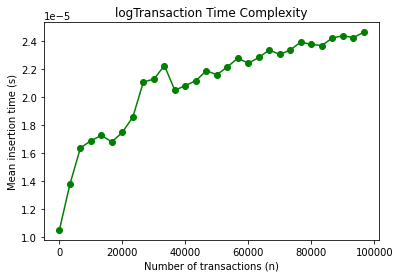

In [7]:
import matplotlib.pyplot as plt

################################################################################
# Graph: LogTransactions shows logarithmic behaviour                           #
################################################################################

x, y = graphInsertionBehaviour(100000, 30)


# Plot marker and line
plt.plot(x, y, color="green")
plt.scatter(x, y, color="green")

plt.title("logTransaction Time Complexity")
plt.xlabel("Number of transactions (n)")
plt.ylabel("Mean insertion time (s)")
plt.show()

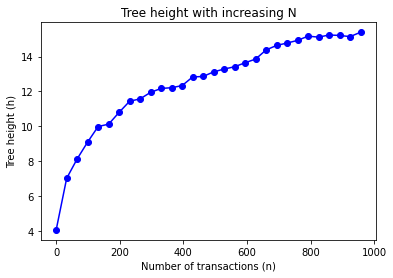

In [8]:
################################################################################
# Graph: Tree height grows logarithmically                                     #
################################################################################

x, y = graphTreeHeightBehaviour(1000, 30)

# Plot marker and line
plt.plot(x, y, color="blue")
plt.scatter(x, y, color="blue")

plt.title("Tree height with increasing N")
plt.xlabel("Number of transactions (n)")
plt.ylabel("Tree height (h)")
plt.show()

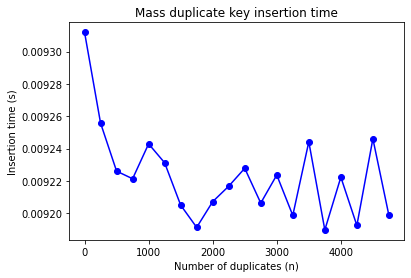

In [9]:
##############################################################################
# Graph: Tree test duplicate keys insertion                                  #
##############################################################################

x, y = testDuplicateKeyBehaviour(10000, 20)

# Plot marker and line
plt.plot(x, y, color="blue")
plt.scatter(x, y, color="blue")

plt.title("Mass duplicate key insertion time")
plt.xlabel("Number of duplicates (n)")
plt.ylabel("Insertion time (s)")
plt.show()

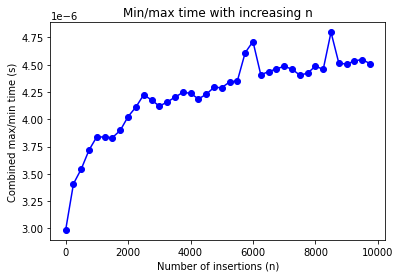

In [10]:
##############################################################################
# Graph: Min / max with increasing n                                         #
##############################################################################

x, y = graphMinMaxBehaviour(10000, 40)

# Plot marker and line
plt.plot(x, y, color="blue")
plt.scatter(x, y, color="blue")

plt.title("Min/max time with increasing n")
plt.xlabel("Number of insertions (n)")
plt.ylabel("Combined max/min time (s)")
plt.show()

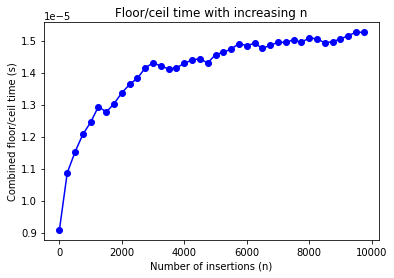

In [11]:
##############################################################################
# Graph: Floor/ceil with increasing n                                        #
##############################################################################

x, y = graphFloorCeilBehaviour(10000, 40)

# Plot marker and line
plt.plot(x, y, color="blue")
plt.scatter(x, y, color="blue")

plt.title("Floor/ceil time with increasing n")
plt.xlabel("Number of insertions (n)")
plt.ylabel("Combined floor/ceil time (s)")
plt.show()

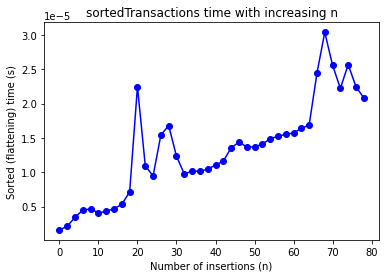

In [14]:
##############################################################################
# Graph: Sorted transactions with increasing n                               #
##############################################################################

x, y = graphSortedBehaviour(10000, 40)

# Plot marker and line
plt.plot(x, y, color="blue")
plt.scatter(x, y, color="blue")

plt.title("sortedTransactions time with increasing n")
plt.xlabel("Number of insertions (n)")
plt.ylabel("Sorted (flattening) time (s)")
plt.show()

Text(0, 0.5, 'Range (flattening) time (s)')

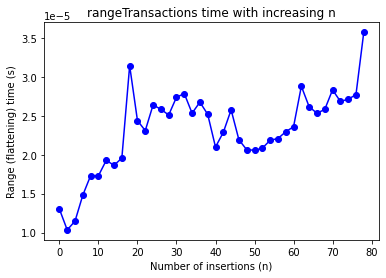

In [17]:
##############################################################################
# Graph: Range transactions with increasing n                                #
##############################################################################

x, y = graphRangeBehaviour(10000, 40)

# Plot marker and line
plt.plot(x, y, color="blue")
plt.scatter(x, y, color="blue")

plt.title("rangeTransactions time with increasing n")
plt.xlabel("Number of insertions (n)")
plt.ylabel("Range (flattening) time (s)")